Attention allows models to weight the importance of different parts of the input sequence when processing each element.

In [2]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self,embed_dim):
        super().__init__()
        self.embed_dim=embed_dim
        self.query=nn.Linear(embed_dim,embed_dim)
        self.key=nn.Linear(embed_dim,embed_dim)
        self.value=nn.Linear(embed_dim,embed_dim)

    def forward(self,query,key,value):
        # Implement attention mechanism
        pass


    

## Self_Attention

Allows a sequence to attend itself, capturing relationship between different positions within the same sequence.It's a key component in understanding context and dependencies in sequential data

In [3]:
def self_attention(self,x):
    # formula: atten(Q,K,V)=softmax((QK^T)/(sqrt(dk))*V)
    
    # input tensor of shape (batch_size,seq_len,embed_dim)
    q=self.query(x)
    k=self.key(x)
    v=self.value(x)


    # compute attention scores 
    scores=torch.matmul(q,k.transpose(-2,-1))/(self.embed_dim**0.5)  #the last and second last dimension will be swapped
    attn_weights=torch.softmax(scores,dim=-1)

    return torch.matmul(attn_weights,v)


Visualization 

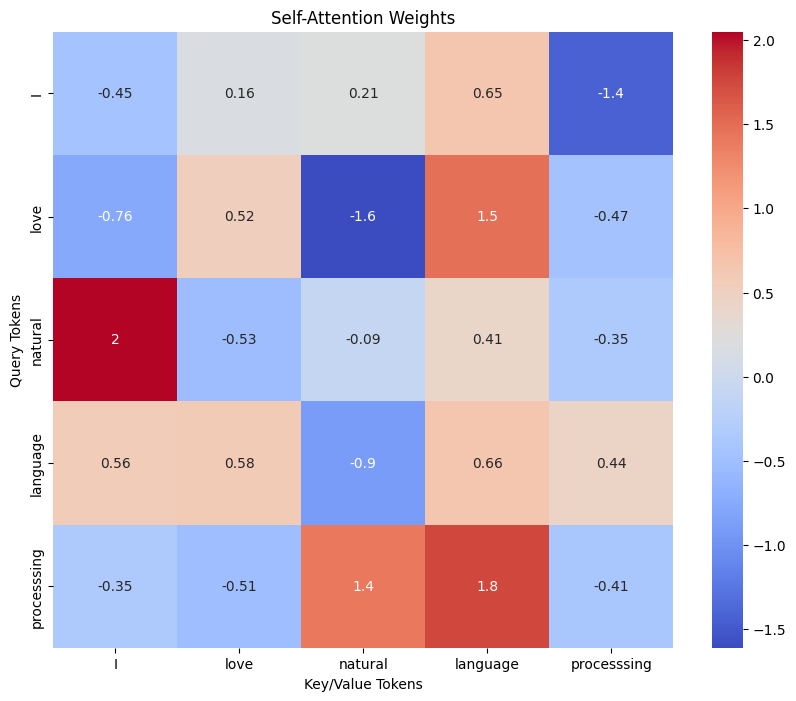

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attn_weights,tokens):
    plt.figure(figsize=(10,8))
    sns.heatmap(attn_weights.detach().numpy(),annot=True,cmap='coolwarm',xticklabels=tokens,yticklabels=tokens)
    plt.title('Self-Attention Weights')
    plt.xlabel('Key/Value Tokens')
    plt.ylabel('Query Tokens')
    plt.show()


# Example Usage
tokens=['I','love','natural','language','processsing']
attn_weights=torch.randn(5,5)
visualize_attention(attn_weights,tokens)


## Multi Head Attention

Allows model to jointly attend to information from different representation subspaces, enhancing the model's ablity to capture various aspect of the input

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self,embed_dim,num_heads):
        super().__init__()
        self.embed_dim=embed_dim
        self.num_heads=num_heads
        self.head_dim=embed_dim//num_heads


        self.query=nn.Linear(embed_dim,embed_dim)
        self.key=nn.Linear(embed_dim,embed_dim)
        self.value=nn.Linear(embed_dim,embed_dim)
        self.out=nn.Linear(embed_dim,embed_dim)

    def forward(self,query,key,value):
        batch_size=query.shape[0]

        # Linear projections and reshape

        q=self.query(query).view(batch_size,-1,self.num_heads,self.head_dim).transpose(1,2)
        k=self.key(key).view(batch_size,-1,self.num_heads,self.head_dim).transpose(1,2)
        v=self.value(value).view(batch_size,-1,self.num_heads,self.head_dim).transpose(1,2)



        # compute attention scroes
        scores=torch.matmul(q,k.transpose(-2,-1)/(self.head_dim**0.5))
        attn_weights=torch.softmax(scores,dim=-1)

        # apply attettion to values
        context=torch.matmul(attn_weights,v)

        # Reshape and apply output projection
        context=context.transpose(1,2).contiguous().view(batch_size,-1,self.embed_dim)
        return self.out(context)
    

    


## Cross-Attention: Bridging sequence

it allows a model to attend to a different sequence than the one being  processed. This is crucial in taks like machine translation, where the model needs to align source and target sequences.

In [6]:
def cross_attention(query,key,value):
    # query: tensor of shape (batch_size,query_len,embe_dim)
    # key,value: tensor of shape(batch_size,key_len,emb_dim)

    scores=torch.matmul(query,key.transpose(-2,-1))/(query.size(-1)**0.5)

    attn_weights=torch.softmax(scores,dim=-1)
    return torch.matmul(attn_weights,value)

# example usage
query=torch.rand(1,5,64) # 5 query token
key=value=torch.rand(1,7,64) #7 key value token

output=cross_attention(query,key,value)
print(f"Cross-attention output shape: {output.shape}")

Cross-attention output shape: torch.Size([1, 5, 64])


## Practical application

text summarization is practical application of self-attention and cross-attention. The model attends to inportant parts  of the inputtext to generate a concise summary

In [10]:
class SummarizationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,num_heads):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embed_dim)
        self.self_attention=MultiHeadAttention(embed_dim,num_heads)
        self.cross_attention=MultiHeadAttention(embed_dim,num_heads)
        self.feed_forward=nn.Sequential(
            nn.Linear(embed_dim,4*embed_dim),
            nn.ReLU(),
            nn.Linear(4*embed_dim,embed_dim)

        )
        self.output=nn.Linear(embed_dim,vocab_size)

    def forward(self,source,target):
        src_embed=self.embedding(source)
        tgt_embed=self.embedding(target)

        # Self-attention on source
        src_attended=self.self_attention(src_embed,src_embed,src_embed)

        # cross attention between target and source
        cross_attended=self.cross_attention(tgt_embed,src_attended,src_attended)


        # feed forward
        output=self.feed_forward(cross_attended)

        return self.output(output)
    


# example usage
vocab_size,embed_dim,num_heads=1000,256,8
model=SummarizationModel(vocab_size,embed_dim,num_heads)
source=torch.randint(0,vocab_size,(1,100))
target=torch.randint(0,vocab_size,(1,20))
output=model(source,target)
print(f"summarization model output shape: {output.shape}")




    

summarization model output shape: torch.Size([1, 20, 1000])


In language modelling task we use maske self-attention to prevent the model from attending to future tokens during training. This ensures model only uses past and present information to predict the next token

In [12]:
def masked_self_attention(x):
    seq_len=x.size(1)
    mask=torch.triu(torch.ones(seq_len,seq_len),diagonal=1).bool() #triu returns the upper traingular part of the matrix
    mask=mask.unsqueeze(0).unsqueeze(0)


    q=self.query(x)
    k=self.key(x)
    v=self.value(x)


    scores=torch.matmul(q,k.transpose(-2,-1))/(self.embed_dim**0.5)
    scores=scores.masked_fill(mask,float('-inf'))
    attn_weights=torch.softmax(scores,dim=-1)

    return torch.matmul(attn_weights,v)



x=torch.randn(1,10,64) #batch size 1 , 10 tokens 64 dimension
output=masked_self_attention(x)
print(f'Masked self attention output shape: {output.shape}')




TypeError: masked_self_attention() missing 1 required positional argument: 'x'

## Positional encoding

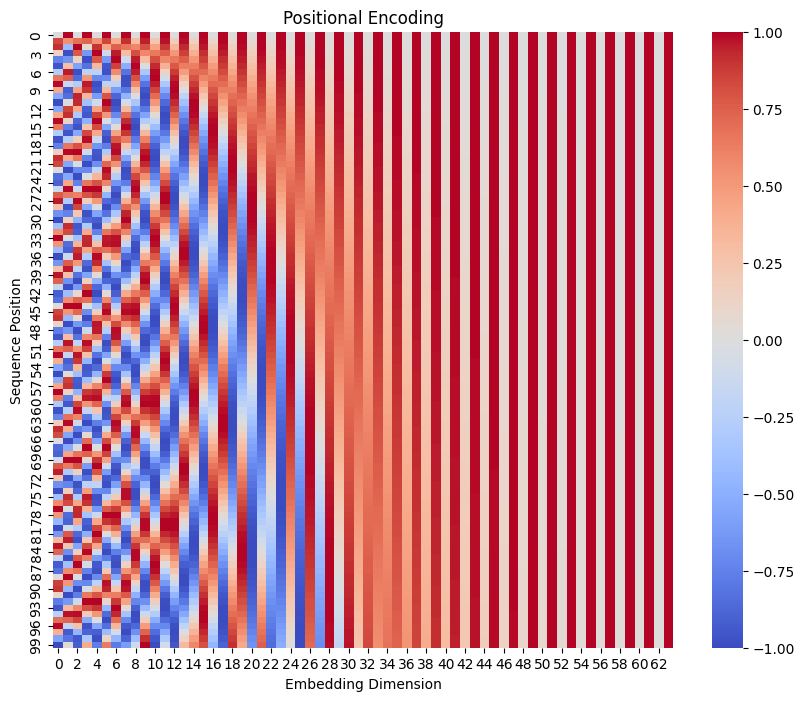

In [13]:
import math

def positional_encoding(seq_len,embed_dim):
    pos=torch.arange(seq_len).unsqueeze(-1)
    div_term=torch.exp(torch.arange(0,embed_dim,2)*-(math.log(10000.0)/embed_dim))
    pe=torch.zeros(seq_len,embed_dim)
    pe[:,0::2]=torch.sin(pos*div_term)
    pe[:,1::2]=torch.cos(pos*div_term)
    return pe



seq_len,embed_dim=100,64
pe=positional_encoding(seq_len,embed_dim)
plt.figure(figsize=(10,8))
sns.heatmap(pe.detach().numpy(),cmap='coolwarm')
plt.title('Positional Encoding')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.show()

